In [1]:
import argparse
import geopandas as gpd
import logging
import numpy as np
import os
import os.path as osp
import pandas as pd
import warnings
from shapely.geometry import box
from shapely import wkt
from pyproj import Geod
import psycopg2
from matplotlib import pyplot as plt
import sys 
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from utils.geometric_utils import read_vector_data, save_geodataframe , create_logger
from utils.haversine_distance import get_distance

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
us_geodata = read_vector_data('us-state-boundaries.geojson')
us_geodata.head(4)

,gid,arealand,division,intptlat,name,objectid,areawater,intptlon,oid,funcstat,...,state,statens,centlat,basename,mtfcc,region,lsadc,geoid,geo_point_2d,geometry
0,16,278176477,0,18.217648,Puerto Rico,50,628200285,-66.410799,303146031,A,...,72,01779808,18.216472,Puerto Rico,G4000,9,00,72,"{'lon': -66.4146425123, 'lat': 18.2157325628}","MULTIPOLYGON (((-67.20794 18.44228, -67.21713 ..."
1,23,472276664,0,14.936784,Commonwealth of the Northern Mariana Islands,36,349301029,145.601021,-1625647860,A,...,69,01779809,16.797438,Commonwealth of the Northern Mariana Islands,G4000,9,00,69,"{'lon': 145.595809651, 'lat': 16.8164771029}","MULTIPOLYGON (((145.57260 15.12502, 145.64831 ..."
2,31,1627312771,7,34.895526,Arkansas,44,-1334552525,-92.444626,266078934,A,...,05,00068085,34.894021,Arkansas,G4000,3,00,05,"{'lon': -92.4393557454, 'lat': 34.899695632}","POLYGON ((-94.55218 36.10224, -94.58620 36.299..."
3,35,2136109036,5,38.647285,West Virginia,1,489848791,-80.618327,-1929409300,A,...,54,01779805,38.641186,West Virginia,G4000,3,00,54,"{'lon': -80.6137013299, 'lat': 38.6425782646}","POLYGON ((-81.74725 39.09538, -81.74385 39.102..."


## Texas

In [6]:
import pandas as pd
import numpy as np
from glob import glob 

from shapely import wkt
from urllib.parse import quote 
from sqlalchemy import create_engine

In [4]:
county_polygon = us_geodata['geometry'].loc[us_geodata.name=='Texas']

polygon_str = county_polygon.apply(lambda x: wkt.dumps(x)).iloc[0]

print(polygon_str[:550])
# ountry_polygon.to_string()


POLYGON ((-103.9801790002390049 32.0001249996322983, -103.0645100003749945 32.0004240002891009, -103.0646250000030051 32.9998989996923981, -103.0436510000020007 34.0036390000544984, -103.0408950001509965 35.8961010001164027, -103.0417129997610033 36.5004389999800978, -100.0004059996350065 36.4997020001953985, -100.0002769997639973 34.5604499997831027, -99.9924059998718064 34.5593670001857021, -99.9716059999481956 34.5621689998304973, -99.9588989996742043 34.5712709999859982, -99.9567169999340024 34.5765239999411023, -99.9538170001433031 34.5785


<AxesSubplot:>

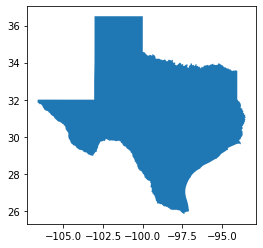

In [5]:
county_polygon.plot()

In [15]:
class ExtractMSFTData:
    def __init__(self, database_name='mnr',databse_server='caprod-cpp-pgmnr-002.flatns.net'):
        self.__logger__ = create_logger()
        self.host = databse_server
        self.database_name = database_name
        self.connection = self.connect_to_server()
        if self.connection:
            print("connection successfull..")
        
    def connect_to_server(self,username='cerebroadmin',password='admin@123'):
        """
        Connect to MNR Database
        :return: connection object
        """
        connection = None
        db_connection_url = "postgresql://cerebroadmin:%s@10.128.154.4:5432/postgres" % quote(password)
        alchemyengine = create_engine(db_connection_url)
        try:
            connection = alchemyengine.connect()
        except (Exception, psycopg2.DatabaseError) as error:
            self.__logger__.error("{}".format(error))
        return connection
    
    def extract_bfp(self,polygon,save=True,filename='country.shp'):
        sql_query = "SELECT st_transform(geometry, 4326) AS geom FROM dev_ppa.msft_building_footprints WHERE ST_Within(geometry,st_transform(ST_GeomFromText('{}',4326),3857))".format(polygon)
        # print(sql_query)
        gdf = gpd.GeoDataFrame.from_postgis(sql_query, self.connection)
        gdf = gdf.to_crs("epsg:4326")
        if save:
            gdf.to_file(filename, driver='ESRI Shapefile')
        return gdf



test = ExtractMSFTData()
filepath = '/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data/Texas'
test.extract_bfp(polygon=polygon_str,save=True,filename=os.path.join(filepath,'Texas.shp'))

connection successfull..


,geom
0,"POLYGON ((-101.61328 35.64147, -101.61328 35.6..."
1,"POLYGON ((-101.62001 35.63241, -101.62051 35.6..."
2,"POLYGON ((-101.61267 35.63932, -101.61281 35.6..."
3,"POLYGON ((-101.62204 35.63721, -101.62186 35.6..."
4,"POLYGON ((-101.62742 35.63801, -101.62759 35.6..."
...,...
10694199,"POLYGON ((-95.27376 30.12879, -95.27388 30.128..."
10694200,"POLYGON ((-95.27138 30.12860, -95.27137 30.128..."
10694201,"POLYGON ((-95.27678 30.12397, -95.27697 30.123..."
10694202,"POLYGON ((-95.27065 30.12938, -95.27053 30.129..."


## Get All the Pkl files

In [8]:
data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data"
country = "Texas"
# read pkl data
pkl_path = os.path.join(data_path,country,'Apt_realignment_MSFT/')
pkl_files = glob(pkl_path+'*/*.pkl')
print("Number of pkl files found ",len(pkl_files))

Number of pkl files found  452


In [9]:
def read_data(fname):
    df_bfp = pd.read_pickle(fname)
    df_bfp.reset_index(drop=True)
    return df_bfp

out = pd.concat([read_data(fname) for fname in pkl_files])

In [11]:
out.head()

,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,PRCLDMPID,updated_geometries,apt_bfp_dist
9,96e6ceed-ba17-4d05-b783-125c17a3e482,Latn,ENG,75803-2822,537,TX,Palestine,AN County Road 429,USA,None,None,None,None,AN County Road 429,100660192_87197953,POINT (-95.71473 31.77511),33.2
21,8d230ceb-b963-40ee-a1db-4ae8b89b8e93,Latn,ENG,75803-3162,376,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197943,POINT (-95.73252 31.77534),163.5
21,c673c387-0835-4678-bfec-2dc90d382d2f,Latn,ENG,75803-3165,428,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197943,POINT (-95.73252 31.77534),143.0
22,86feaf8e-a868-42b4-940e-bc31fec7b092,Latn,ENG,75803-3165,448,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197942,POINT (-95.73298 31.77599),160.6
22,f02202a7-1650-4c9b-a487-6e7aabeb83cf,Latn,ENG,75803-3165,466,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197942,POINT (-95.73298 31.77599),159.8


In [12]:
out.to_pickle(os.path.join(pkl_path,'Final_Updated_geom_{}.pkl'.format(country)))

## Post data to DB

In [13]:
passowrd = 'admin@123'
db_connection_url = "postgresql://cerebroadmin:%s@10.128.154.4:5432/postgres" % quote(passowrd)
con = create_engine(db_connection_url)

In [17]:
output_pkl = os.path.join(pkl_path,'Final_Updated_geom_{}.pkl'.format(country))
updated_pkl = pd.read_pickle(output_pkl)

gdf = gpd.GeoDataFrame(updated_pkl, crs=4326,geometry='updated_geometries')
gdf.head()

,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,PRCLDMPID,updated_geometries,apt_bfp_dist
9,96e6ceed-ba17-4d05-b783-125c17a3e482,Latn,ENG,75803-2822,537,TX,Palestine,AN County Road 429,USA,None,None,None,None,AN County Road 429,100660192_87197953,POINT (-95.71473 31.77511),33.2
21,8d230ceb-b963-40ee-a1db-4ae8b89b8e93,Latn,ENG,75803-3162,376,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197943,POINT (-95.73252 31.77534),163.5
21,c673c387-0835-4678-bfec-2dc90d382d2f,Latn,ENG,75803-3165,428,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197943,POINT (-95.73252 31.77534),143.0
22,86feaf8e-a868-42b4-940e-bc31fec7b092,Latn,ENG,75803-3165,448,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197942,POINT (-95.73298 31.77599),160.6
22,f02202a7-1650-4c9b-a487-6e7aabeb83cf,Latn,ENG,75803-3165,466,TX,Palestine,Broyles Chapel Rd,USA,None,Rd,None,None,Broyles Chapel,100660192_87197942,POINT (-95.73298 31.77599),159.8


In [23]:
gdf.to_postgis(name="updated_APT_Texas", schema='dev_apa', con=con, index=False, if_exists='append')